In [12]:
import os
import math
import random
from typing import Dict, Literal, List, Set, Tuple, Iterable

import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt

files = os.listdir('DataSujetos/')

In [7]:
class Experiment():
    
    def __init__(self, density: float):
        self.density = density
        algorithms = ['louvain', 'girvan', 'lpa']
        self._data = {x: {'modularity': {}, 'NC': {}} for x in algorithms}
        
    def set_experiment_data(self, 
                            data: Dict[str, float], 
                            algo: Literal['louvain', 'girvan', 'lpa'], 
                            measurement: Literal['modularity', 'NC']) -> None:
        self._data[algo][measurement].update(data)
            
    def get_estadio_data(self, 
                        algo: Literal['louvain', 'girvan', 'lpa'],
                        measurement: Literal['modularity', 'NC'],
                        estadio: Literal['W', 'N1', 'N2', 'N3', 'ER']) -> np.ndarray:
        res = []
        for k, v in self._data[algo][measurement].items():
            if k.startswith(estadio):
                res.append(v)
        return np.array(res)

In [8]:
def find_threshold(adj_matrix: np.ndarray, density: float, epsilon: int=2) -> float:
    size = adj_matrix.shape
    N = size[0]*size[1]
    left = adj_matrix.min()
    right = adj_matrix.max()
    target = math.ceil(N*density)
    res = N
    cnt = 0
    limit = 100
    while res!=target:
        cnt+=1
        if cnt == limit:
            print(f'Have not converged in {limit} iterations, returning suboptimal threshold')
            return guess
        guess = (left+right)/2
        res = np.sum(adj_matrix>=guess)
        if (res>=target-epsilon) and (res<=target+epsilon):
            return guess
        elif res<target:
            right = guess
        else:
            left = guess

            
def _community_detection_strategy(G: nx.Graph, algo: str) -> Dict[str, float]:
    if algo == 'louvain':
        comms = nx.community.louvain_communities(G, seed=158151)
    elif algo == 'lpa':
        comms = nx.community.label_propagation_communities(G)
    elif algo == 'girvan':
        Girvan_generator = nx.community.girvan_newman(G)
        comms = next(Girvan_generator)
    else:
        raise NotImplementedError
    NC = len([x for x in comms if len(x)>1])
    Q = nx.community.modularity(G, comms)
    return {'NC': NC, 'modularity': Q}


def run_community_detection(G: nx.Graph, f: str, exp: Experiment, algo:str) -> None:
    data = _community_detection_strategy(G, algo)
    exp.set_experiment_data({f: data['modularity']}, algo, 'modularity')
    exp.set_experiment_data({f: data['NC']}, algo, 'NC')
    
    
def graph_factory(adjmat: np.ndarray) -> nx.Graph:
    adjmat -= np.diag(np.diag(adjmat))
    thr = find_threshold(adjmat, d)
    adjmat = adjmat>=thr
    G = nx.from_numpy_array(adjmat)
    return G
    

def reset_avg(estadio_avg_graph: Dict[str, np.ndarray], cnt_by_estadio: Dict[str, int]) -> None:
    for k in estadio_avg_graph:
        estadio_avg_graph[k] = np.zeros((116, 116))
        cnt_by_estadio[k] = 0

In [9]:
%%time

densities = np.linspace(0.01, 0.15, num=15)
experiments = [Experiment(d) for d in densities]
algorithms = ['louvain', 'girvan', 'lpa']
estadio_avg_graph = {
    'W': np.zeros((116, 116)),
    'N1': np.zeros((116, 116)),
    'N2': np.zeros((116, 116)),
    'N3': np.zeros((116, 116)),
}
cnt_by_estadio = {
    'W': 0,
    'N1': 0,
    'N2': 0,
    'N3': 0,
}

for i, d in enumerate(densities):
    print(f'Start with density {d}')
    for f in files:
        exp = experiments[i]
        adjmat = pd.read_csv('DataSujetos/'+f, header=None).values
        for k in estadio_avg_graph:
            if f.startswith(k):
                estadio_avg_graph[k] += adjmat
                cnt_by_estadio[k] += 1
        G = graph_factory(adjmat)
        for algo in algorithms:
            run_community_detection(G, f, exp, algo)
    for k in estadio_avg_graph:
        adjmat = estadio_avg_graph[k]/cnt_by_estadio[k]
        G = graph_factory(adjmat)
        for algo in algorithms:
            run_community_detection(G, f'avg_{k}', exp, algo)
    for cnt in range(18):
        ERG = nx.erdos_renyi_graph(n=116, p=d, seed=random.randint(0,1000000), directed=False)
        for algo in algorithms:
            run_community_detection(ERG, f'ER_{cnt}', exp, algo)
    reset_avg(estadio_avg_graph, cnt_by_estadio)

Start with density 0.01
Start with density 0.019999999999999997
Start with density 0.03
Start with density 0.039999999999999994
Start with density 0.049999999999999996
Have not converged in 1000 iterations, returning suboptimal threshold
Start with density 0.05999999999999999
Start with density 0.06999999999999999
Start with density 0.07999999999999999
Start with density 0.08999999999999998
Start with density 0.09999999999999998
Start with density 0.10999999999999997
Start with density 0.11999999999999998
Start with density 0.12999999999999998
Start with density 0.13999999999999999
Start with density 0.15
CPU times: total: 6min 23s
Wall time: 6min 24s


# Graphs and experiments

In [127]:
def plot_experimental_comparison(comparations: List[Tuple[str]],
                                 densities: np.ndarray,
                                 averages: Dict[str, List[float]],
                                 std_errors: Dict[str, List[float]],
                                 name: str) -> None:
    fig, axs = plt.subplots(ncols= len(comparations), figsize=(15, 4))

    for i, c in enumerate(comparations):
        ax = axs[i]
        y = np.array(averages[c[0]])
        ci = np.array(std_errors[c[0]])
        x = densities
        ax.set_xlabel('Densidad')
        ax.set_ylabel(name)
        ax.plot(x,y, label=c[0])
        ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

        y = np.array(averages[c[1]])
        ci = np.array(std_errors[c[1]])
        x = densities
        ax.set_title(f'{c[0]} vs {c[1]}')
        ax.set_xlabel('Densidad')
        ax.set_ylabel(name)
        ax.plot(x,y, color= 'r', label=c[1])
        ax.fill_between(x, (y-ci), (y+ci), color='r', alpha=.1)
        ax.legend()

    plt.tight_layout()
    
    
def run_t_tests_with_FDR(exp_data: Iterable[float], compare_with: str) -> None:
    estadios = ['N1', 'N2', 'N3']
    total_pvals = []
    if compare_with != 'W':
        estadios.append('W')
    for estadio in estadios:
        pvals = []
        for i, d in enumerate(densities):
            print(f'Density Value: {d}')
            t_test_result = ttest_ind(exp_data[estadio][i], exp_data[compare_with][i], equal_var=False)
            p_val = t_test_result.pvalue
            significant_symbol = '***' if p_val<0.05 else ''
            print(f"""{estadio}: {t_test_result} {significant_symbol}""")
            pvals.append(p_val)
        total_pvals.extend(pvals)
        if compare_with=='ER':
            print(f'FDR correction for multiple hypotheses for density {d}')
            print(fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=False))
    if compare_with=='W':
        print(f'FDR correction for multiple hypotheses for density {d}')
        print(fdrcorrection(total_pvals, alpha=0.05, method='indep', is_sorted=False))

# Plots for Louvain algo

In [128]:
estadios = ['W', 'N1', 'N2', 'N3', 'ER']

Qs = {e: [exp.get_estadio_data('louvain', 'modularity', e) for exp in experiments] for e in estadios}
QCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in Qs.items()}
Qavgs = {e: [np.mean(x) for x in data] for e, data in Qs.items()}
NCs = {e: [exp.get_estadio_data('louvain', 'NC', e) for exp in experiments] for e in estadios}
NCCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in NCs.items()}
NCavgs = {e: [np.mean(x) for x in data] for e, data in NCs.items()}

Plots comparing different sleep states with Awoken state


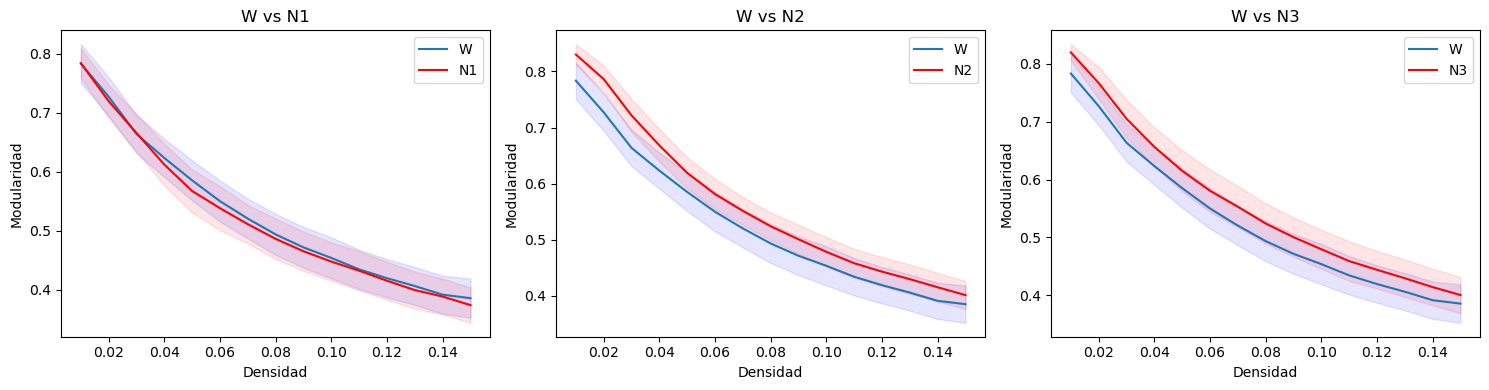

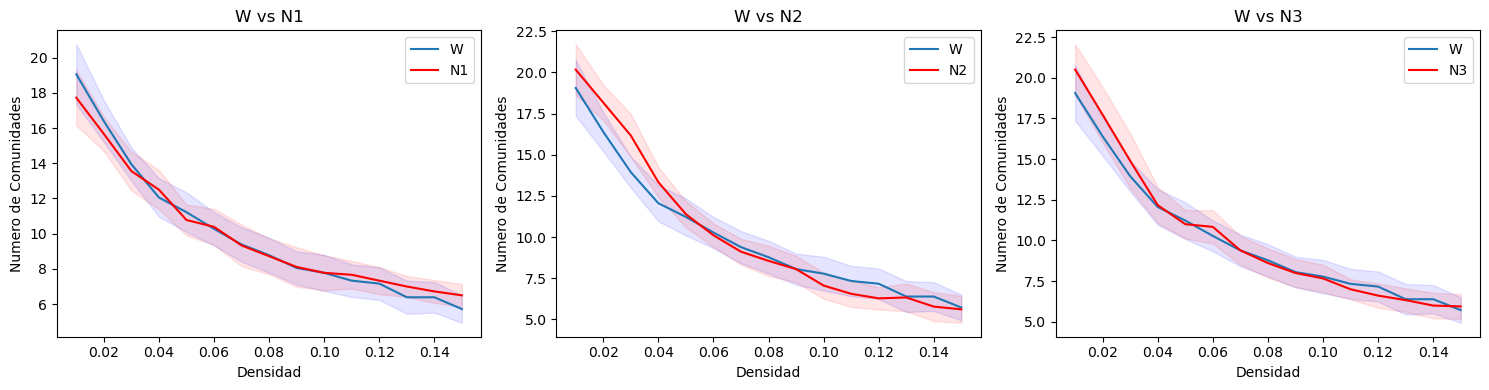

In [129]:
print('Plots comparing different sleep states with Awoken state')
comparaciones = [('W','N1'),('W','N2'),('W','N3')]
plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Qavgs,
                             std_errors=QCIs,
                             name='Modularidad')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=NCavgs,
                             std_errors=NCCIs,
                             name='Numero de Comunidades')

Plots comparing different sleep states with Random graph


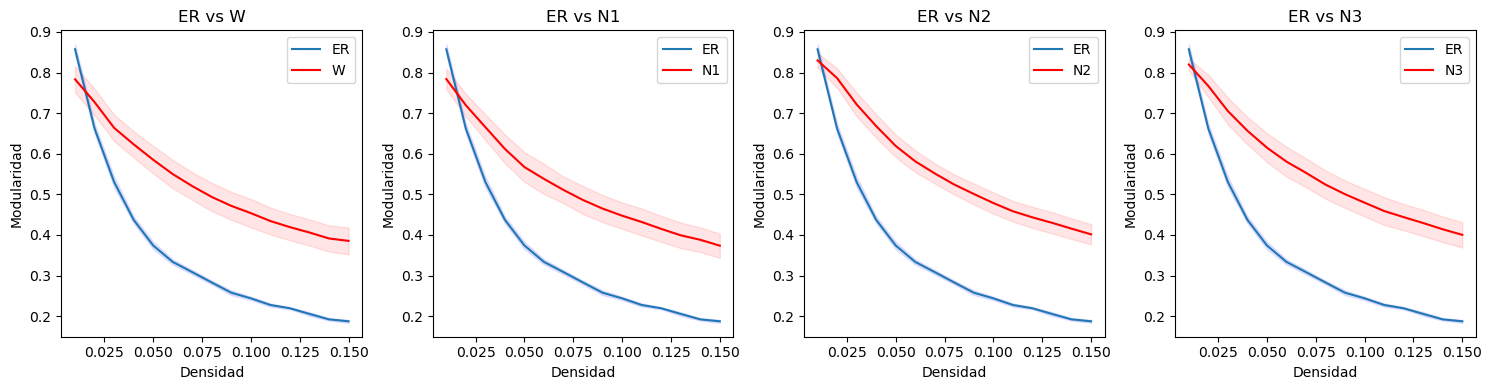

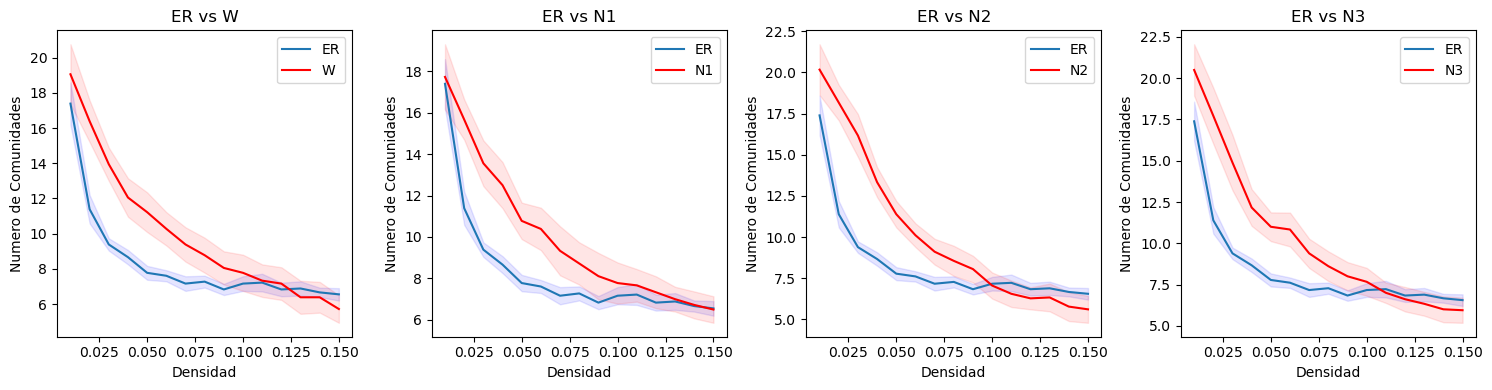

In [130]:
print('Plots comparing different sleep states with Random graph')

comparaciones = [('ER','W'),('ER','N1'),('ER','N2'),('ER','N3')]
plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Qavgs,
                             std_errors=QCIs,
                             name='Modularidad')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=NCavgs,
                             std_errors=NCCIs,
                             name='Numero de Comunidades')

In [131]:
# Test suite for Louvain

print('RUNNING TESTS FOR MODULARITY Q, COMPARING WITH RANDOM GRAPH')
run_t_tests_with_FDR(Qs, compare_with='ER')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR NUMBER OF COMMUNITIES NC, COMPARING WITH RANDOM GRAPH')
run_t_tests_with_FDR(NCs, compare_with='ER')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR MODULARITY Q, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(Qs, compare_with='W')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR NUMBER OF COMMUNITIES NC, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(NCs, compare_with='W')

RUNNING TESTS FOR MODULARITY Q, COMPARING WITH RANDOM GRAPH
Density Value: 0.01
N1: Ttest_indResult(statistic=-4.912409712161744, pvalue=4.8871339169591704e-05) ***
Density Value: 0.019999999999999997
N1: Ttest_indResult(statistic=3.607331933273017, pvalue=0.0014767860384372348) ***
Density Value: 0.03
N1: Ttest_indResult(statistic=7.522686495902292, pvalue=1.4352640556282565e-07) ***
Density Value: 0.039999999999999994
N1: Ttest_indResult(statistic=9.169787040389789, pvalue=2.19914782119654e-08) ***
Density Value: 0.049999999999999996
N1: Ttest_indResult(statistic=9.799953340434026, pvalue=7.485651828198875e-09) ***
Density Value: 0.05999999999999999
N1: Ttest_indResult(statistic=10.296315792972704, pvalue=5.672672084850149e-09) ***
Density Value: 0.06999999999999999
N1: Ttest_indResult(statistic=11.587826281829539, pvalue=9.264022060281155e-10) ***
Density Value: 0.07999999999999999
N1: Ttest_indResult(statistic=11.11212584650902, pvalue=2.144872378710333e-09) ***
Density Value: 0.08

# Informe

### Tarea 2, punto 1
Louvain community detection, comparing modularity Q in random graph vs brain graph
Los coeficientes de modularidad para los grafos cerebrales en todos los estados - W, N1, N2, N3 - son estadísticamente significativamente diferentes de un grafo aleatorio en todos los umbrales de densidad, incluso después de la corrección de hipótesis múltiples utilizando el método FDR de Benjamini-Hochberg. Esta diferencia es claramente visible en las figuras anteriores.

### Tarea 2, punto 2
Louvain community detection, comparing number of communities NC in random graph vs brain graph
En cuanto al número de comunidades, los resultados no son tan concluyentes. No todos los umbrales de densidad muestran significancia estadística en el número de comunidades en el grafo cerebral frente al grafo aleatorio. Sin embargo, para todos los estados cerebrales, el número de comunidades (NC) es estadísticamente significativamente diferente de un grafo aleatorio en umbrales de densidad entre 0.02 y 0.08.

### Tarea 2, punto 3
Louvain community detection, comparing modularity Q and number of communities NC in W state vs sleep states N1, N2, N3
Con Louvain como algoritmo de detección de comunidades, no logramos observar significancia estadística en el coeficiente de modularidad entre el estado W y cualquiera de los estados de sueño en ningún umbral de densidad después de la corrección FDR. El resultado es el mismo para el número de comunidades.

### Tarea 2, punto 4
Los gráficos se encuentran al final del notebook.

### Tarea 2, opcional 1
- Louvain vs label propagation (LPA)
Los gráficos de modularidad son similares, aunque el algoritmo LPA parece tener una mayor incertidumbre en los coeficientes de modularidad. Además, el algoritmo LPA logró separar mejor los estados W vs. N2 en algunos umbrales. El algoritmo LPA separa de manera significativamente mejor el grafo aleatorio del grafo cerebral en lo que respecta al número de comunidades en umbrales de densidad más altos.
- Louvan vs Girvan
Girvan parece tener un rendimiento similar al de Louvain, pero logra separar mejor los grafos aleatorios de los grafos cerebrales en lo que respecta al número de comunidades.
### Tarea 2, opcional 2
Plantee conceptualmente (es decir en palabras)
las hipótesis estadísticas que se evaluaron con los tests de significancia de los puntos anteriores. ¿Qué es lo que se evaluó? Discuta especificamente si resulta necesario corregir por
comparaciones múltiples para hacer afirmaciones sobre diferencias entre estadíos, y cómo lo
haría

Cuatro hipótesis independientes:

1. Existe una diferencia entre el coeficiente de modularidad de un grafo aleatorio y un grafo cerebral. Se requiere corrección FDR, ya que realizamos la prueba estadística en 15 valores distintos del umbral de densidad.
2. Existe una diferencia entre el coeficiente de modularidad del estado despierto y cualquiera de los estados de sueño. Se requiere corrección FDR, ya que realizamos la prueba estadística en 45 valores distintos del umbral de densidad.
3. Existe una diferencia entre el número de comunidades de un grafo aleatorio y un grafo cerebral. Se requiere corrección FDR, ya que realizamos la prueba estadística en 15 valores distintos del umbral de densidad.
4. Existe una diferencia entre el número de comunidades del estado despierto y cualquiera de los estados de sueño. Se requiere corrección FDR, ya que realizamos la prueba estadística en 45 valores distintos del umbral de densidad.
No es necesario realizar corrección de hipótesis múltiples entre estas 4 hipótesis.

# LPA algorithm

In [132]:
estadios = ['W', 'N1', 'N2', 'N3', 'ER']

Qs = {e: [exp.get_estadio_data('lpa', 'modularity', e) for exp in experiments] for e in estadios}
QCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in Qs.items()}
Qavgs = {e: [np.mean(x) for x in data] for e, data in Qs.items()}
NCs = {e: [exp.get_estadio_data('lpa', 'NC', e) for exp in experiments] for e in estadios}
NCCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in NCs.items()}
NCavgs = {e: [np.mean(x) for x in data] for e, data in NCs.items()}

Plots comparing different sleep states with Awoken state


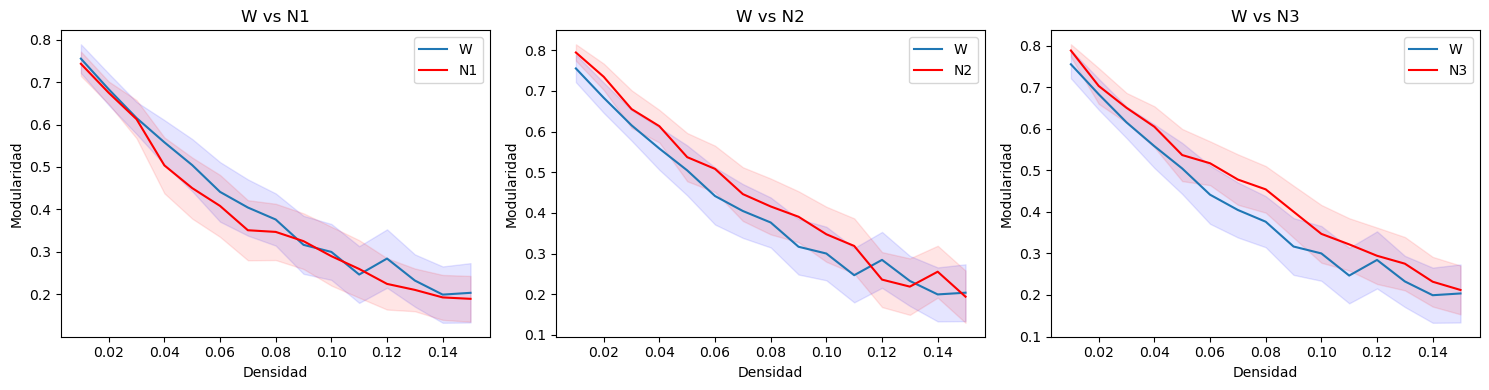

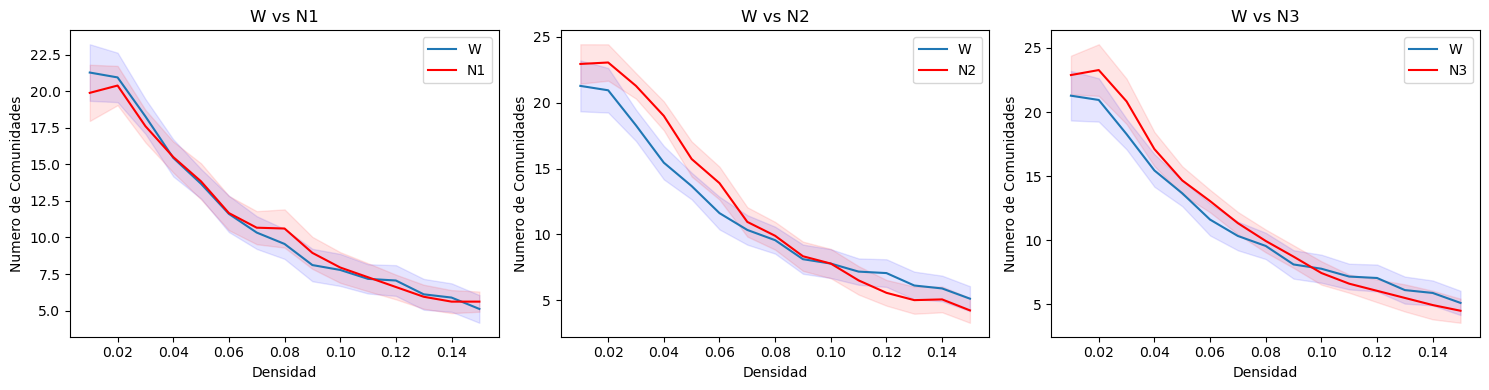

In [133]:
print('Plots comparing different sleep states with Awoken state')
comparaciones = [('W','N1'),('W','N2'),('W','N3')]
plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Qavgs,
                             std_errors=QCIs,
                             name='Modularidad')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=NCavgs,
                             std_errors=NCCIs,
                             name='Numero de Comunidades')

Plots comparing different sleep states with Random graph


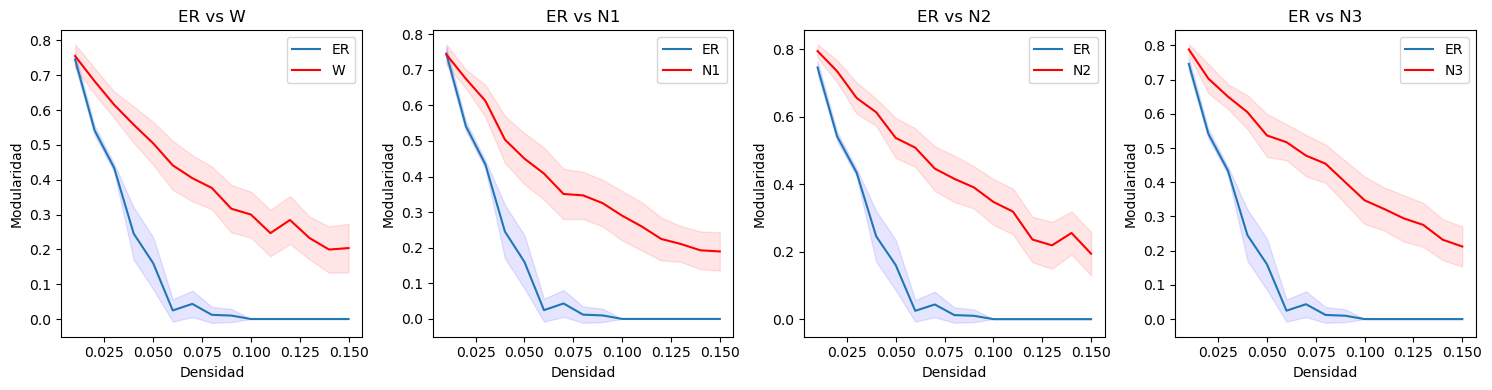

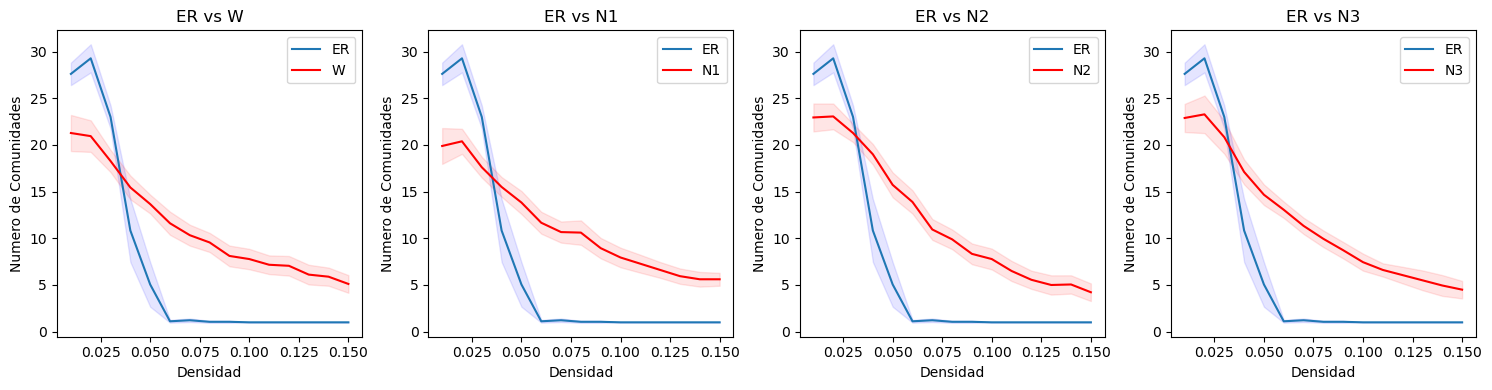

In [134]:
print('Plots comparing different sleep states with Random graph')

comparaciones = [('ER','W'),('ER','N1'),('ER','N2'),('ER','N3')]
plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Qavgs,
                             std_errors=QCIs,
                             name='Modularidad')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=NCavgs,
                             std_errors=NCCIs,
                             name='Numero de Comunidades')

In [135]:
# Test suite for LPA

print('RUNNING TESTS FOR MODULARITY Q, COMPARING WITH RANDOM GRAPH')
run_t_tests_with_FDR(Qs, compare_with='ER')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR NUMBER OF COMMUNITIES NC, COMPARING WITH RANDOM GRAPH')
run_t_tests_with_FDR(NCs, compare_with='ER')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR MODULARITY Q, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(Qs, compare_with='W')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR NUMBER OF COMMUNITIES NC, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(NCs, compare_with='W')

RUNNING TESTS FOR MODULARITY Q, COMPARING WITH RANDOM GRAPH
Density Value: 0.01
N1: Ttest_indResult(statistic=-0.1497890665957625, pvalue=0.8819493765993365) 
Density Value: 0.019999999999999997
N1: Ttest_indResult(statistic=8.500508542412858, pvalue=6.818408363105785e-09) ***
Density Value: 0.03
N1: Ttest_indResult(statistic=7.316733244605368, pvalue=5.901477249468761e-07) ***
Density Value: 0.039999999999999994
N1: Ttest_indResult(statistic=4.927901076211836, pvalue=2.2154116393869852e-05) ***
Density Value: 0.049999999999999996
N1: Ttest_indResult(statistic=5.330377119206195, pvalue=6.420762244477383e-06) ***
Density Value: 0.05999999999999999
N1: Ttest_indResult(statistic=9.169497576905169, pvalue=3.288800978512034e-09) ***
Density Value: 0.06999999999999999
N1: Ttest_indResult(statistic=7.309490202572689, pvalue=9.350050026200248e-08) ***
Density Value: 0.07999999999999999
N1: Ttest_indResult(statistic=9.105816465538455, pvalue=9.75476178767391e-09) ***
Density Value: 0.0899999999

C:\Users\USER\AppData\Local\Temp\ipykernel_10916\3918753359.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_test_result = ttest_ind(exp_data[estadio][i], exp_data[compare_with][i], equal_var=False)


# Girvan algorithm

In [136]:
estadios = ['W', 'N1', 'N2', 'N3', 'ER']

Qs = {e: [exp.get_estadio_data('girvan', 'modularity', e) for exp in experiments] for e in estadios}
QCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in Qs.items()}
Qavgs = {e: [np.mean(x) for x in data] for e, data in Qs.items()}
NCs = {e: [exp.get_estadio_data('girvan', 'NC', e) for exp in experiments] for e in estadios}
NCCIs = {e: [1.96*np.std(x)/np.sqrt(len(x)) for x in data] for e, data in NCs.items()}
NCavgs = {e: [np.mean(x) for x in data] for e, data in NCs.items()}

Plots comparing different sleep states with Awoken state


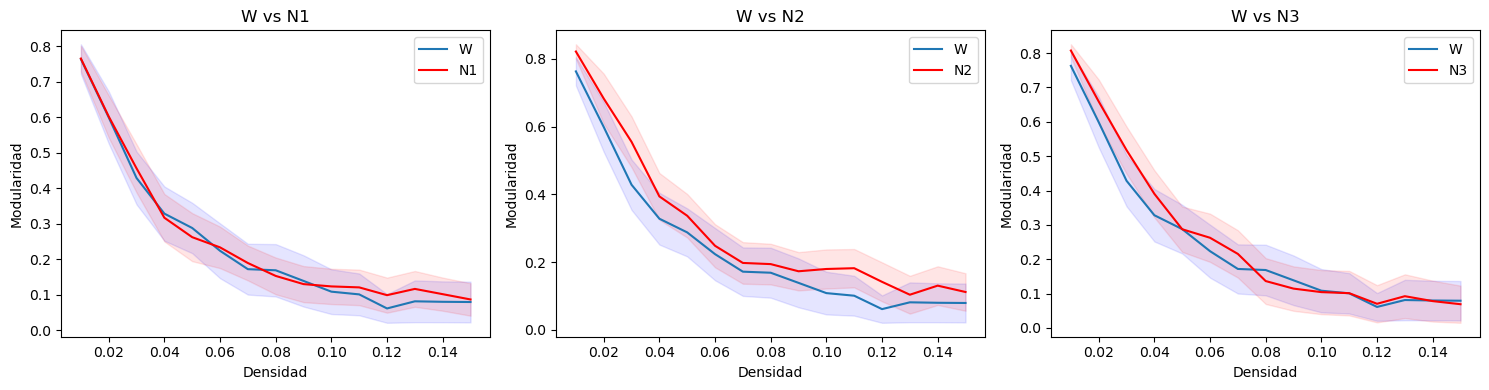

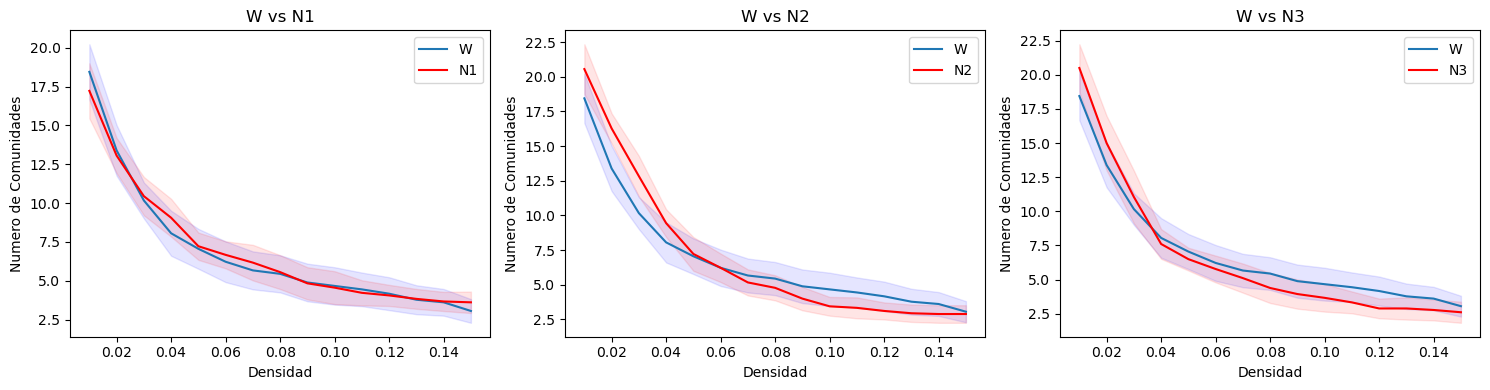

In [137]:
print('Plots comparing different sleep states with Awoken state')
comparaciones = [('W','N1'),('W','N2'),('W','N3')]
plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Qavgs,
                             std_errors=QCIs,
                             name='Modularidad')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=NCavgs,
                             std_errors=NCCIs,
                             name='Numero de Comunidades')

Plots comparing different sleep states with Random graph


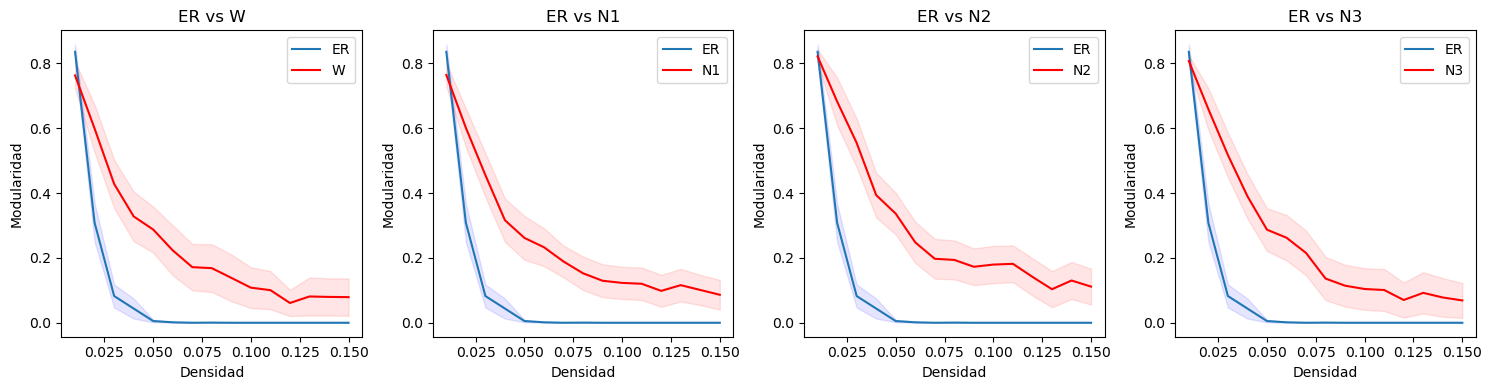

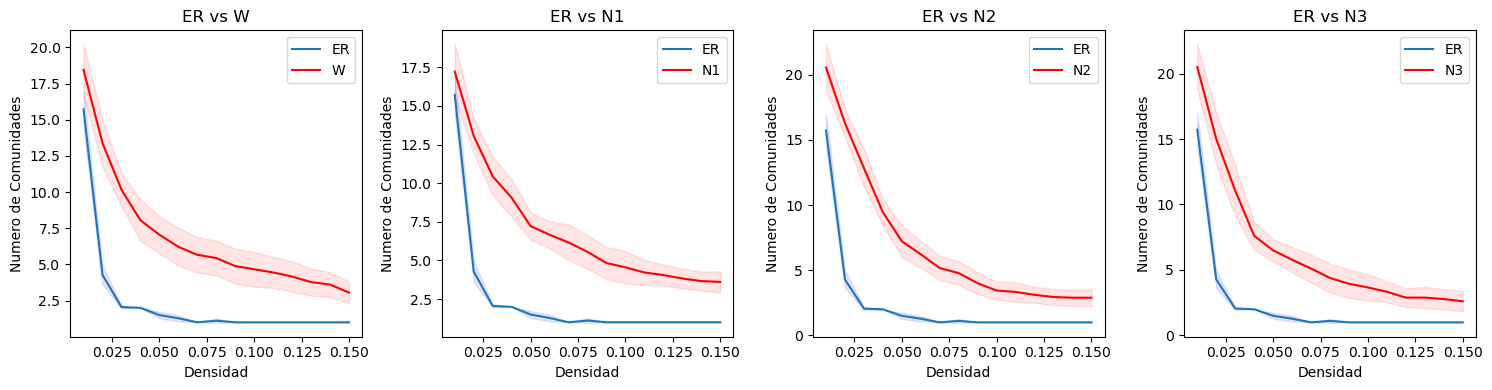

In [138]:
print('Plots comparing different sleep states with Random graph')

comparaciones = [('ER','W'),('ER','N1'),('ER','N2'),('ER','N3')]
plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=Qavgs,
                             std_errors=QCIs,
                             name='Modularidad')

plot_experimental_comparison(comparations=comparaciones,
                             densities=densities,
                             averages=NCavgs,
                             std_errors=NCCIs,
                             name='Numero de Comunidades')

In [139]:
# Test suite for Girvan

print('RUNNING TESTS FOR MODULARITY Q, COMPARING WITH RANDOM GRAPH')
run_t_tests_with_FDR(Qs, compare_with='ER')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR NUMBER OF COMMUNITIES NC, COMPARING WITH RANDOM GRAPH')
run_t_tests_with_FDR(NCs, compare_with='ER')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR MODULARITY Q, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(Qs, compare_with='W')
print()
print('###################################################################')
print()
print('RUNNING TESTS FOR NUMBER OF COMMUNITIES NC, COMPARING WITH AWAKE W')
run_t_tests_with_FDR(NCs, compare_with='W')

RUNNING TESTS FOR MODULARITY Q, COMPARING WITH RANDOM GRAPH
Density Value: 0.01
N1: Ttest_indResult(statistic=-3.1545977844789577, pvalue=0.003711944607121246) ***
Density Value: 0.019999999999999997
N1: Ttest_indResult(statistic=6.658480442648551, pvalue=1.2182389059644057e-07) ***
Density Value: 0.03
N1: Ttest_indResult(statistic=9.259710943090539, pvalue=1.182754952728531e-09) ***
Density Value: 0.039999999999999994
N1: Ttest_indResult(statistic=7.04998746984874, pvalue=2.7720578814293083e-07) ***
Density Value: 0.049999999999999996
N1: Ttest_indResult(statistic=7.209395057533826, pvalue=1.4091955829322113e-06) ***
Density Value: 0.05999999999999999
N1: Ttest_indResult(statistic=7.554640995144703, pvalue=7.860761485091606e-07) ***
Density Value: 0.06999999999999999
N1: Ttest_indResult(statistic=7.343746323922971, pvalue=1.1471087270544701e-06) ***
Density Value: 0.07999999999999999
N1: Ttest_indResult(statistic=5.600040963978687, pvalue=3.18404163774481e-05) ***
Density Value: 0.089

C:\Users\USER\AppData\Local\Temp\ipykernel_10916\3918753359.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_test_result = ttest_ind(exp_data[estadio][i], exp_data[compare_with][i], equal_var=False)


In [140]:
%%time

avg_graphs = {}

for i, d in enumerate([0.06]):
    print(f'Start with density {d}')
    for f in files:
        adjmat = pd.read_csv('DataSujetos/'+f, header=None).values
        for k in estadio_avg_graph:
            if f.startswith(k):
                estadio_avg_graph[k] += adjmat
                cnt_by_estadio[k] += 1
    for k in estadio_avg_graph:
        adjmat = estadio_avg_graph[k]/cnt_by_estadio[k]
        G = graph_factory(adjmat)
        avg_graphs[k] = G
        
communities = {
    k: nx.community.louvain_communities(v, seed=158151) for k, v in avg_graphs.items()
}

Start with density 0.06
CPU times: total: 406 ms
Wall time: 975 ms


In [141]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]

In [142]:
def plot_brain_graph(avg_graphs: Dict[str, nx.Graph], 
                     communities: Dict[str, Iterable[int]], 
                     estadio: str) -> None:
    G = avg_graphs[estadio]
    comm_color = [-1 for i in range(116)]
    for i, comm in enumerate(communities[estadio]):
        for node in comm:
            comm_color[node] = i+3 if len(comm)>1 else -1
    n=116
    nodes = G.nodes()
    plt.figure(figsize=(9,6))
    plt.title('Con nodos coloreados de acuerdo a su grado', fontsize=14)
    layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
    vmin = min(comm_color)
    vmax = max(comm_color)
    cmap=plt.cm.Blues
    nx.draw(G, layout, node_size=20, node_color=comm_color, vmin=vmin, vmax=vmax,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    plt.colorbar(sm)

C:\Users\USER\AppData\Local\Temp\ipykernel_10916\846253344.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


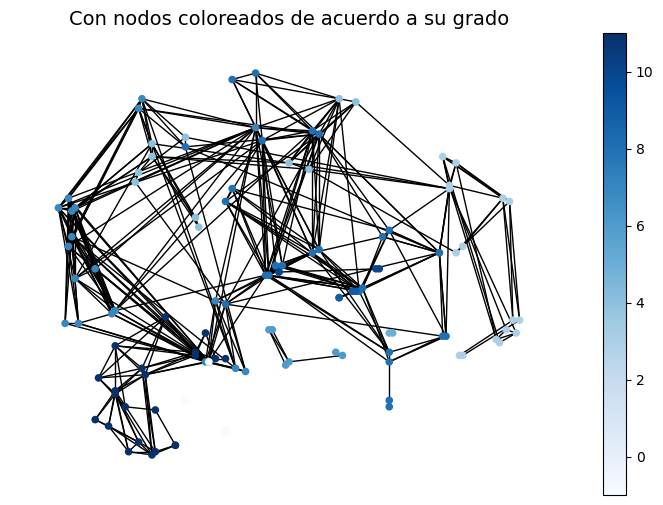

In [51]:
plot_brain_graph(avg_graphs,communities,'W')

C:\Users\USER\AppData\Local\Temp\ipykernel_10916\846253344.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


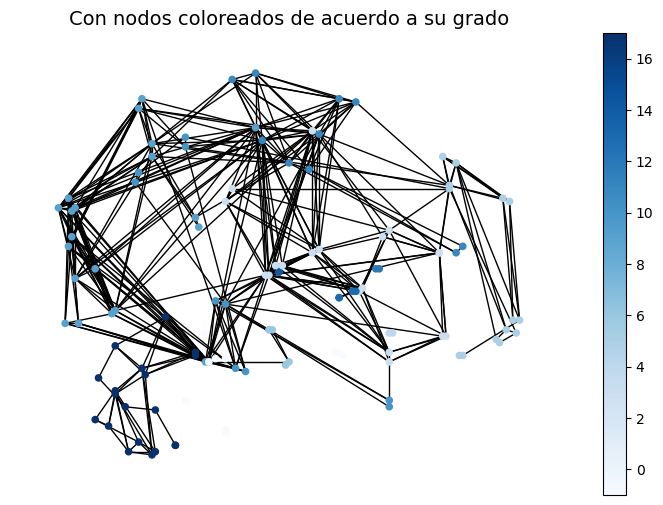

In [52]:
plot_brain_graph(avg_graphs,communities,'N1')

C:\Users\USER\AppData\Local\Temp\ipykernel_10916\846253344.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


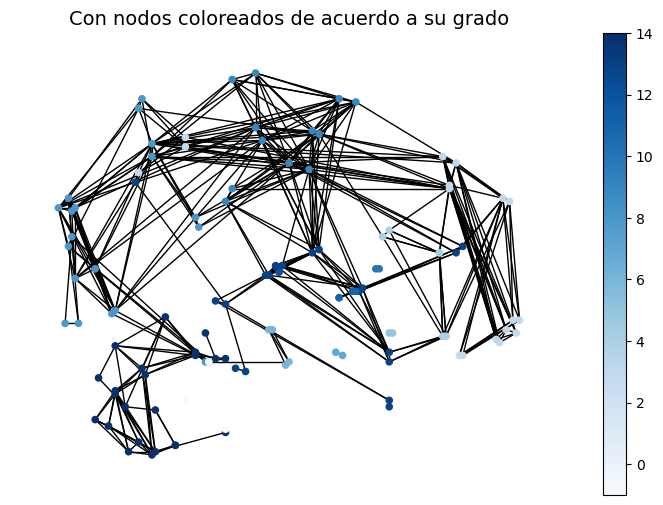

In [53]:
plot_brain_graph(avg_graphs,communities,'N2')

C:\Users\USER\AppData\Local\Temp\ipykernel_10916\846253344.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


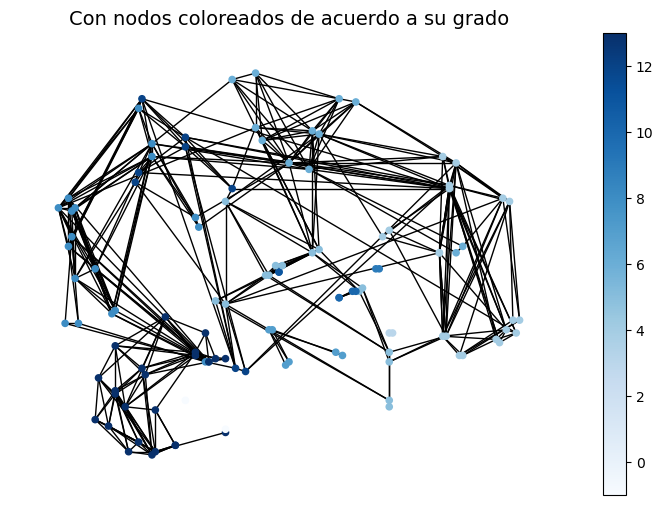

In [54]:
plot_brain_graph(avg_graphs,communities,'N3')